In [399]:
# Load some libraries
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
import seaborn as sns
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import geopy
import ee
import geemap

In [400]:
# magic command to render plots in notebook
%matplotlib inline

In [401]:
# Initialisie google earth engine
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWikTRxfPjCFt8NVQ-dsvvo1hdTPOf0yckcsNLZ1RjddlkBk328Miv0

Successfully saved authorization token.


##  1 - Load Oil Palm Plantations layer

Use google earth engine to load the generated 10m global industrial and smallholder oil palm map for 2019. It covers areas where oil palm plantations were detected. The classified images are the output of a convolutional neural network based on Sentinel-1 and Sentinel-2 half-year composites.

In [402]:
# Load a polygon of Indoensia so that we can clip the global palm oil dataset
indoMap = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017') \
         .filter(ee.Filter.eq('country_co', 'ID'))

# Load the palm oil map
globalPalm = ee.ImageCollection('BIOPAMA/GlobalOilPalm/v1')

# Function to clip image collection
def clipIC(image):
    return image.clip(indoMap)

# Clip image collection to extend of Indonesia
indoPalm = globalPalm.map(clipIC).select('classification')

# Select pixels that represent:
# 1 - Industrial closed-canopy oil palm plantations 
# 2 - Smallholder closed-canopy oil palm plantations
# Composite image set using mosaic
# Remove all pixels not equal to plantations
mosaic = indoPalm.mosaic()
mask = mosaic.neq(3)
# Generate an image to show all Indonesian palm oil plantations
plantImage = mask.updateMask(mask)

### 2 - Map Global Administrative Unit Layers (GAUL) 2015 over Palm Oil Plantations

Google Earth Engine has af product that contains polygons of municiapl regions (so called Level 2 administratuve units). These are key units to exploring deforestation for palm oil plantations, across Indonesia.

In [403]:
# Filter GAUL to Indonesia
indoGaul = ee.FeatureCollection("FAO/GAUL/2015/level2") \
.filter(ee.Filter.eq('ADM0_NAME', "Indonesia"))

Lets plot a map to show palm plantations by kabupaten

In [404]:
# Create a map
Map = geemap.Map()
# Centre on Indonesia
Map.setCenter(101.6162, 0.9028,8)
# Add layers - palm oil plantation
Map.addLayer(plantImage, {'palette' : 'red'}, 'Plantations', True)
# GAUL level2 regions - aka Kabupaten
Map.addLayer(indoGaul, {'opacity': 0.4, 'width' : 1}, 'Kabupaten', True)
Map

Map(center=[0.9028, 101.6162], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

1 - plantation/dept area = plantation risk
2 - plantation/kba area = kba risk
3 - absolute deforestation risk

### 3 - Palm Oil Plantation area per Kabupaten

Here we calculate coverage of platations within Indonesian Kabupaten (administrative departments)

In [405]:
# Functionn to map over kabupaten (features) within the Indonesian featureCollection
def mapKabupaten(kabupaten):
    
    # Calculate kabupaten area
    kabArea = kabupaten.geometry().area().divide(1e6).round()
    
    # Set a property within the kabupaten feature to capture the county area
    kabupaten = kabupaten.set('Kabupaten_Area', kabArea)
    
    # Calculate total palm oil plantations area within a kabupaten
    plantationArea = plantImage.reduceRegion(
        reducer   = ee.Reducer.sum(),
        geometry  = kabupaten.geometry(),
        scale     = 10,
        maxPixels = 1e10
    ).get("classification")
    
    # Convert plantation area into km2
    plantationArea = ee.Number.float(plantationArea).divide(1e4)
    
    # Set a property within the kabupaten feature to capture total plantation area for the kabupaten
    kabupaten = kabupaten.set('Plantation_Area', plantationArea)
    
    # Percentage of Kabupaten taken up by palm oil plantations
    percentagePlantation = plantationArea.divide(kabArea).multiply(100)
    
    # Set a property within the kabupaten feature to capture the % palm oil plantation
    kabupaten = kabupaten.set('Plantation_Per', percentagePlantation)

    # return updated feature
    return kabupaten
    
# Map over uk counties and calulcate the county area and the broadleaf woodland area within it
kabupatenPlantationStats = indoGaul.map(mapKabupaten)

In [406]:
# Calculate area of all Kabupaten (size of Indonesia in km2)
areaOfIndonesia = kabupatenPlantationStats.aggregate_sum("Kabupaten_Area").getInfo()
areaOfIndonesia

1896976

In [407]:
# Calculate area of all Palm Oil plantations (in km2)
areaOfPlantations = kabupatenPlantationStats.aggregate_sum("Plantation_Area").getInfo()
areaOfPlantations

116239.46698705881

What percentage of Indonesia is given over to palm oil?

In [408]:
round(areaOfPlantations/areaOfIndonesia * 100,2)

6.13

Let's look at the % coverage by Kabupaten:

In [409]:
# Convert featurecollection to dataframe
plantationStats_df = geemap.ee_to_df(kabupatenPlantationStats)

If we sort this in descending order, we can see which Kabupaten have the highest % coverage. Two of them are over 50% covered in palm oil plantations...

In [410]:
plantationStats_df[["ADM2_NAME","Kabupaten_Area","Plantation_Area","Plantation_Per"]] \
.sort_values("Plantation_Area", ascending=False) \
.head(10)

,ADM2_NAME,Kabupaten_Area,Plantation_Area,Plantation_Per
64,Kotawaringin Timur,16247,"5,270.71",32.44
358,Labuhanbatu,9604,"4,825.28",50.24
34,Kampar,10688,"4,659.54",43.60
38,Rokanhulu,8044,"4,362.99",54.24
16,Kutai Timur,28497,"4,292.57",15.06
299,Ketapang,34675,"3,832.76",11.05
37,Rokanhilir,8919,"2,998.45",33.62
63,Kotawaringin Barat,11266,"2,789.68",24.76
100,Musibanyuasin,13705,"2,751.42",20.08
68,Seruyan,14396,"2,575.01",17.89


Now let's doe the same, but for key biodiversity areas

### 6 - How are Key Biodiversity Areas affected by palm oil plantation growth?

Let's start by loading the shape file from Birdlife international that contains the Key Biodiversity Areas from the World Database

In [411]:
# Turning warning off for chained expressions
pd.options.mode.chained_assignment = None  # default='warn'

# Load dataset as provided by http://www.keybiodiversityareas.org/
kba = gpd.read_file("data/KBAsGlobal_2021_September_02/KBAsGlobal_2021_September_02_POL.shp")
# Filter on Indonesian KBAs only
kba_indo = kba.loc[kba['ISO3'] == 'IDN']
# Simplify the geometry within the dataframe, in order to speed up calculations
kba_indo["geometry"] = kba_indo.simplify(tolerance=100)
# Let's select only those columns that we need
kba_indo = kba_indo[["SitRecID","IntName","geometry"]]
# Write indonesian data to specific shape file
kba_indo.to_file("data/KBAsIndonesia/KBAs_indonesia.shp")

kba_indo.head()

,SitRecID,IntName,geometry
2716,15801,Rawa Tapus,"POLYGON ((98.12203 2.17013, 98.33067 2.30564, ..."
2717,15803,Pesisir Timur Pantai Sumatera Utara,"MULTIPOLYGON (((98.77468 3.72455, 98.77744 3.7..."
2718,15805,Malampah Alahan Panjang,"POLYGON ((100.00000 0.07152, 100.25377 0.11979..."
2719,15806,Gunung Singgalang,"POLYGON ((100.27946 -0.33319, 100.37172 -0.406..."
2720,15807,Pulau Siberut,"POLYGON ((99.01230 -1.77325, 98.59071 -1.23239..."


In [412]:
# Check the CRS is WGS84
kba_indo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Load the KBA polygon set into GEE as a feature collection - polygon boundaries are simplified for speed.

In [413]:
kbaIndofc = geemap.geopandas_to_ee(kba_indo)

In [414]:
kba_indo

,SitRecID,IntName,geometry
2716,15801,Rawa Tapus,"POLYGON ((98.12203 2.17013, 98.33067 2.30564, ..."
2717,15803,Pesisir Timur Pantai Sumatera Utara,"MULTIPOLYGON (((98.77468 3.72455, 98.77744 3.7..."
2718,15805,Malampah Alahan Panjang,"POLYGON ((100.00000 0.07152, 100.25377 0.11979..."
2719,15806,Gunung Singgalang,"POLYGON ((100.27946 -0.33319, 100.37172 -0.406..."
2720,15807,Pulau Siberut,"POLYGON ((99.01230 -1.77325, 98.59071 -1.23239..."
...,...,...,...
15459,15832,Tanjung Koyan,"MULTIPOLYGON (((105.90582 -2.96044, 105.90215 ..."
15460,15831,Tanjung Selokan,"POLYGON ((105.62708 -2.42003, 105.63164 -2.652..."
15461,15890,Gunung Raung,"POLYGON ((114.13046 -8.05700, 114.12930 -8.157..."
15462,15891,Gunung Ijen,"POLYGON ((114.26006 -7.95246, 114.25355 -8.009..."


In [415]:
Map.addLayer(kbaIndofc, {'opacity': 0.8, 'width' : 1, 'color' : 'yellow'}, "Key Biodiversity Areas")
Map

Map(center=[0.9028, 101.6162], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

Which KBAs have incursion from palm oil plantations?

In [416]:
# Function to map over KBAs in order to determine % coverage by palm oil plantations
def mapKBAs(kba):
    # Calculate kabupaten area
    kbaArea = kba.geometry().area().divide(1e6).round()
    
    # Set a property within the kabupaten feature to capture the county area
    kba = kba.set('KBA_Area', kbaArea)
    
    # Calculate total palm oil plantations area within a KBA
    plantationArea = plantImage.reduceRegion(
        reducer   = ee.Reducer.sum(),
        geometry  = kba.geometry(),
        scale     = 10,
        maxPixels = 1e10
    ).get("classification")
    
    # Convert plantation area into km2
    plantationArea = ee.Number.float(plantationArea).divide(1e4)
    
    # Set a property within the KBA feature to capture total plantation area for the KBA
    kba = kba.set('Plantation_Area', plantationArea)
    
    # Percentage of KBA taken up by palm oil plantations
    percentagePlantation = plantationArea.divide(kbaArea).multiply(100)
    
    # Set a property within the KBA feature to capture the % palm oil plantation
    kba = kba.set('Plantation_Per', percentagePlantation)

    # return updated feature
    return kba
    
# Map over uk counties and calulcate the county area and the broadleaf woodland area within it
KBAPlantationStats = kbaIndofc.map(mapKBAs)

In [417]:
# Calculate area of all Palm Oil plantations (in km2)
areaOfPlantationsWithinKBAs = KBAPlantationStats.aggregate_sum("Plantation_Area").getInfo()
areaOfPlantationsWithinKBAs

3555.7015803921554

In [418]:
# Calculate area of all KBAs (in km2)
areaOfKBAs = KBAPlantationStats.aggregate_sum("KBA_Area").getInfo()
areaOfKBAs

313560

What percentage of key biological areas are now covered by palm oil plantations?

In [419]:
round(areaOfPlantationsWithinKBAs/areaOfKBAs * 100,2)

1.13

1% intrusion doesn't sound much? We have effectively averaged over all KBAs. So there may well be outliers. Which KBAs have the highest intrusion of palm oil plantations?

In [420]:
# Convert featurecollection to dataframe
kbaStats_df = geemap.ee_to_df(KBAPlantationStats)

In [421]:
kbaStats_df[["IntName","KBA_Area","Plantation_Area","Plantation_Per"]] \
.sort_values("Plantation_Per", ascending=False) \
.head(10)

,IntName,KBA_Area,Plantation_Area,Plantation_Per
5,Rawa Lunang,257,129.88,50.54
399,Lae Raso,17,6.41,37.71
94,Delta Mahakam,306,80.74,26.38
18,Pesisir Pantai Jambi,73,18.31,25.08
89,Hutan Kahayan,1397,345.71,24.75
156,Lariang,53,11.03,20.82
103,Tesso Nilo,760,154.54,20.33
32,Bukit Bakar - Bukit Gajah,734,134.48,18.32
0,Rawa Tapus,480,87.38,18.20
14,Rawa Pesisir Pantai Barat Tapanuli Selatan (An...,1220,156.10,12.79


This isn't good. Smaller areas are quite like to be populated with endemics with marginal range.

## 7 - Analysis of exporters with greatest deforestation risk by Kabupaten

The trase website (https://supplychains.trase.earth) has supply chain analysis data for 2015 that shows by Kabupaten, the trade volume exported by exporter,the volume imported by importer and crucially a likely **deforestation risk**. This will give us a view as to which export companies are driving the deforestation of by Kabupaten.

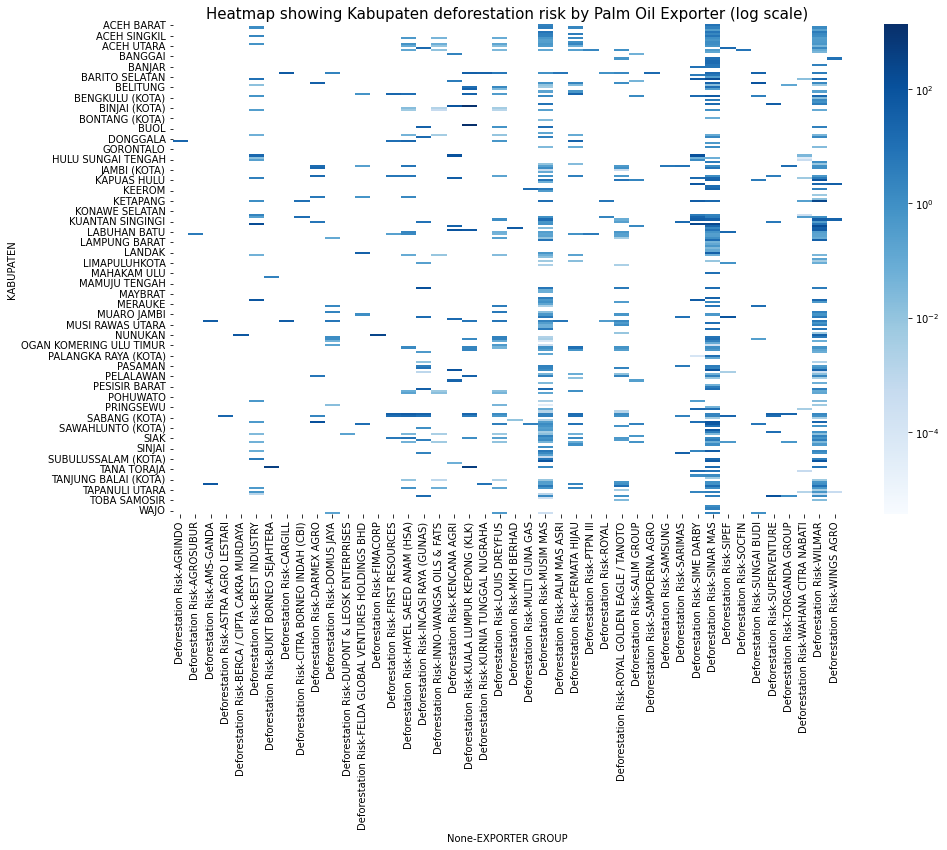

In [422]:
# Read Trase supply chain data for 2015 and eyeball it
trase = pd.read_csv("data/INDONESIA_PALM OIL_1.1.2_tc.2015.csv")
# selecting rows based on Trase deforestation risk indicator
trase = trase.loc[trase['INDICATOR'] == 'OIL_PALM_DEFORESTATION_RISK_HA']
# Fix some datatypes
trase['KABUPATEN'] = trase['KABUPATEN'].astype("string")
trase['TOTAL'] = trase['TOTAL'].astype(float)
trase.rename(columns={'TOTAL':'Deforestation Risk'}, inplace=True)
# Remove domestic consumption
trase = trase[trase["EXPORTER GROUP"] != "DOMESTIC CONSUMPTION"]

riskByKabupatenExporter = pd.pivot_table(trase, 
                                         index=["KABUPATEN"], 
                                         columns="EXPORTER GROUP", 
                                         values=["Deforestation Risk"],
                                         fill_value=0)
# Plot using seaborn - log scale
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(riskByKabupatenExporter,cmap="Blues", norm=LogNorm())
plt.title('Heatmap showing Kabupaten deforestation risk by Palm Oil Exporter (log scale)', fontsize = 15)
plt.show()

## 8 - Analysis of export finance as a driver of deforesation risk

Who is financing palm plantations? We can use (incomplete!) data from Refinitiv to list financial instruments afforded to exporters of palm oil, to understand who their FI counterparties are.

In [423]:
finance = pd.read_csv("data/palm_finance.csv")
finance["Group"] = finance["Group"].str.upper()
finance.rename(columns={'Group':'EXPORTER GROUP'}, inplace=True)

Which banks are the top 25 funders of palm oil export?

In [424]:
finPivot = pd.pivot_table(finance,index=["Bank"],values=["AmountUSDMillions"],aggfunc=np.sum)
finPivot.sort_values(by='AmountUSDMillions',ascending=False).head(25)

,AmountUSDMillions
Bank,
Malayan Banking,"1,056.89"
Oversea-Chinese Banking Corporation,993.14
Bank Mandiri,745.44
CIMB Group,533.64
Bank Rakyat Indonesia,530.73
Bank Central Asia,479.75
Public Bank,473.48
Rabobank,434.72
Bank Negara Indonesia,415.89


Which exporters are the top 25 recipients of the finance?

<AxesSubplot:ylabel='EXPORTER GROUP,Bank'>

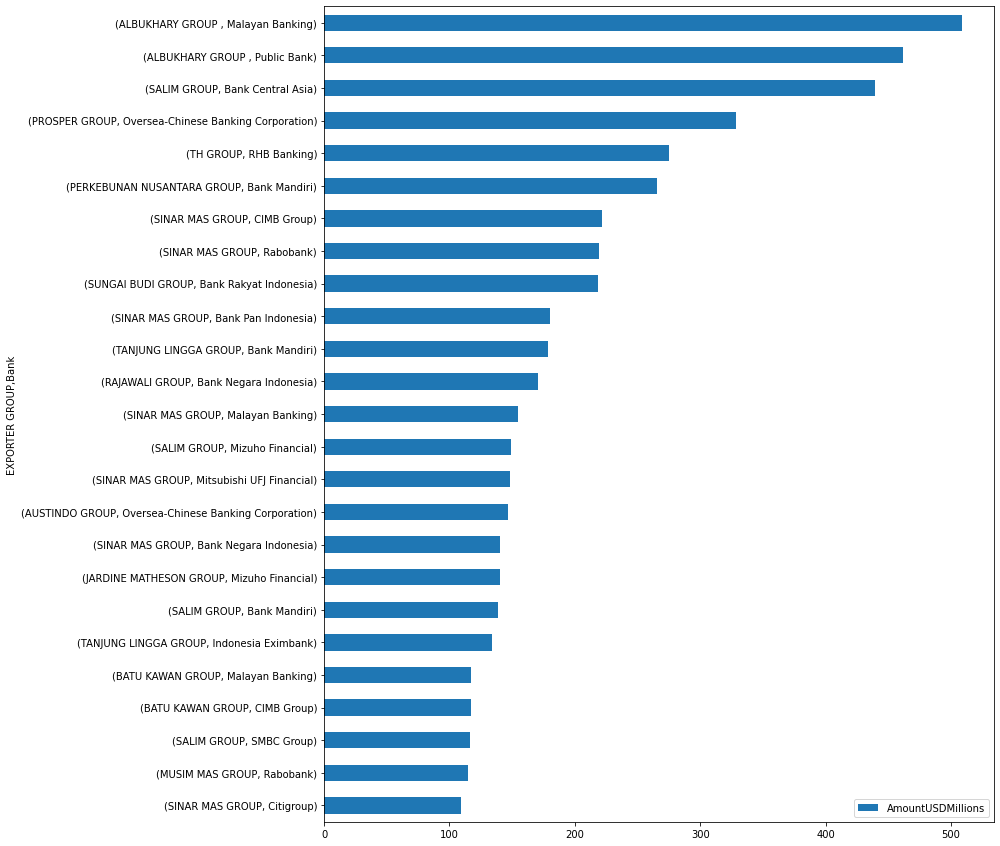

In [439]:
finPivot = pd.pivot_table(finance,index=["EXPORTER GROUP","Bank"],values=["AmountUSDMillions"],aggfunc=np.sum)
finPivot.sort_values(by='AmountUSDMillions',ascending=True).tail(25).plot.barh(rot=0,figsize=(12,15))

What types of exposures are the banks taking?

In [426]:
finPivot = pd.pivot_table(finance,index=["Type"],values=["AmountUSDMillions"],aggfunc=np.sum)
finPivot.sort_values(by='AmountUSDMillions',ascending=False)

,AmountUSDMillions
Type,
Corporate loan,"5,859.18"
Revolving credit facility,"2,351.44"
Bond issuance,"1,707.37"
Share issuance,61.49


Plot a pie chart

<AxesSubplot:ylabel='AmountUSDMillions'>

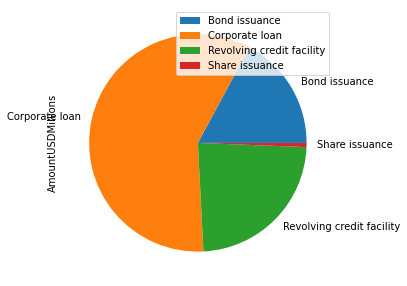

In [427]:
finPivot.plot.pie(y="AmountUSDMillions",figsize=(5,5))

So what deforestation risk do the banks have? We can merge the finance data with the trase data to get an idea of this. Note the finance data is not complete.

In [428]:
exportFinance = finance[["Bank","EXPORTER GROUP","AmountUSDMillions","Key"]]

In [429]:
deforestationRisk = pd.pivot_table(trase,index="EXPORTER GROUP",values="Deforestation Risk",aggfunc=np.sum)

In [430]:
bankRisk = pd.merge(exportFinance, deforestationRisk,left_on="Key",right_on="EXPORTER GROUP", how='inner')

In [431]:
bankRiskPivot = pd.pivot_table(bankRisk,index="Bank",values="Deforestation Risk", aggfunc=np.sum).sort_values('Deforestation Risk')

<AxesSubplot:ylabel='Bank'>

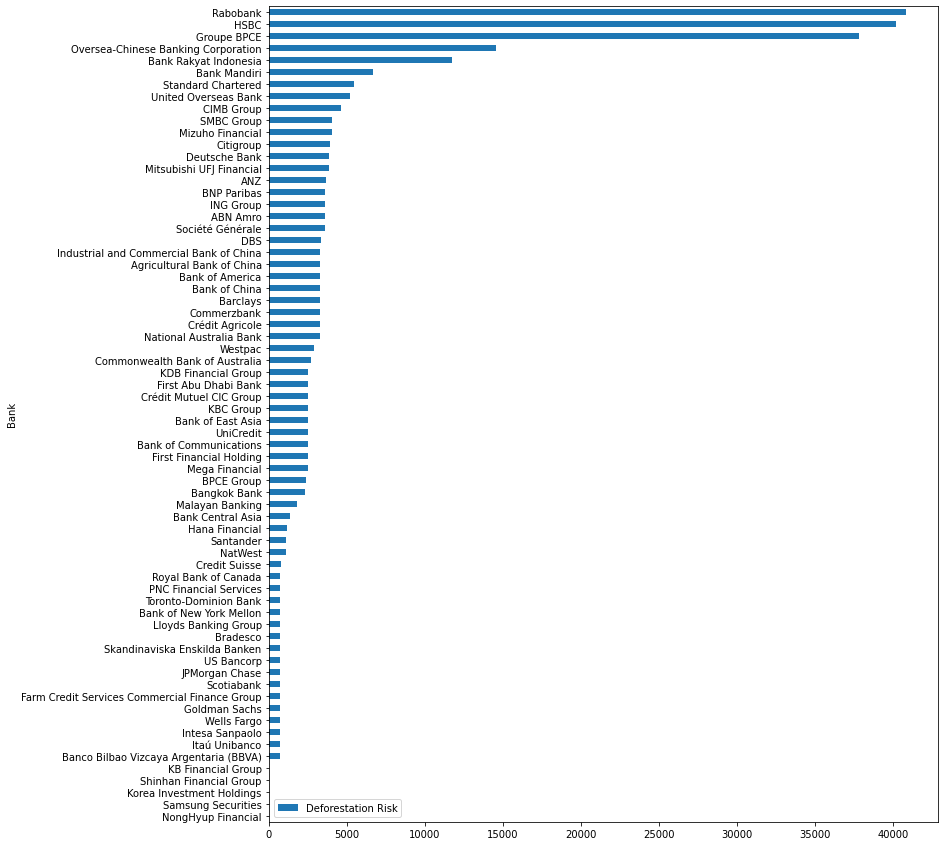

In [432]:
bankRiskPivot.plot.barh(rot=0,figsize=(12,15))

# Summary - what we learned?